In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input,Concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
# 코랩에서 구글 드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### train data 불러와 구조 변경

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train.csv")

In [9]:
data_folder = "/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images"
img_files = [filename for filename in os.listdir(data_folder) if filename.endswith(".jpg")]

list_imgs = []
for each in img_files:
    for i in range (4):
        list_imgs.append(each)

list_type = []
for i in range (int(len(list_imgs)/4)):
    for j in range (4):
        list_type.append(j+1)

new_train = pd.DataFrame()
new_train['ImageId'] = list_imgs
new_train['ClassId'] = list_type

new_train['EncodedPixels'] = [np.nan] * 50272
new_train['has_mask'] = [False] * 50272

for i in tqdm(range(train_df.shape[0])):
    new_train.loc[(new_train.ImageId == train_df.ImageId[i]) & (new_train.ClassId == train_df.ClassId[i]), 'EncodedPixels'] = train_df.loc[(train_df.ImageId == train_df.ImageId[i]) & (train_df.ClassId == train_df.ClassId[i]),'EncodedPixels'].values
    new_train.loc[(new_train.ImageId == train_df.ImageId[i]) & (new_train.ClassId == train_df.ClassId[i]), 'has_mask'] = True

train_df = new_train.copy()

100%|██████████| 1144/1144 [00:09<00:00, 117.08it/s]


### mask count 데이터프레임 생성

In [10]:
mask_count = pd.DataFrame()
mask_count['ImageId'] = train_df.ImageId.unique()
mask_count['has_mask'] =[0] * len(train_df.ImageId.unique())

array_judge = train_df.ImageId
for each in array_judge:
    if each:
         mask_count.loc[mask_count['ImageId'] == each,"has_mask"] += 1

### Mask 생성하기

In [11]:
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [12]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))

    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))

    return masks

def build_rles(masks):
    width, height, depth = masks.shape

    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]

    return rles

### 손실 함수 정의

In [13]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Data Generator 정의 후 train, valid, test 데이터 정의

In [14]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=318, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_batch = [self.list_IDs[k] for k in indexes]

        X = self.__generate_X(list_IDs_batch)

        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y

        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)

    def __generate_X(self, list_IDs_batch):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)

            X[i,] = img

        return X

    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)

        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]

            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)

            y[i, ] = masks

        return y

    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img

In [15]:
BATCH_SIZE = 16

# train valid를 8:2로 등분
train_idx, val_idx = train_test_split(
    mask_count.index, random_state=318, test_size=0.2
)

# valid test를 5:5로 등분
val_idx, test_idx = train_test_split(
    val_idx, random_state=318, test_size=0.5
)
train_generator = DataGenerator(
    train_idx,
    df=mask_count,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    n_classes=4
)
val_generator = DataGenerator(
    val_idx,
    df=mask_count,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    n_classes=4
)
test_generator = DataGenerator(
    test_idx,
    df=mask_count,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    n_classes=4
)

In [17]:
len(train_idx), len(val_idx), len(test_idx)

### Model Architecture

In [18]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = Concatenate()([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = Concatenate()([u71, c4])
    c71 = Conv2D(64, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(64, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])

    return model

In [19]:
model = build_model((256, 1600, 1))

### 🌱 학습 중간에 발생하는 에러로 인해 로드하여 재학습 진행!

### Train the model (dice coef 0.0407 ~ 0.3581) 

- 참고로, 0.3581 이후 0.5787 까지 출력값 저장은 안되어있으나 모델은 계속 업데이트 되었음.

In [ ]:
model.load_weights('/content/drive/MyDrive/졸업과제/모델/model-u-Net.h5')

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    patience=40,               # 몇 번의 에폭 동안 향상이 없으면 조기 중지할지 설정
    min_delta=0.001,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/졸업과제/모델/model-u-Net.h5',
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=100
)

<ipython-input-26-f9e8de76c7bf>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
628/628 [==============================] - ETA: 0s - loss: 1.0174 - dice_coef: 0.0407 
Epoch 1: val_dice_coef improved from -inf to 0.08277, saving model to /content/drive/MyDrive/졸업과제/모델/model-u-Net.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


628/628 [==============================] - 8124s 13s/step - loss: 1.0174 - dice_coef: 0.0407 - val_loss: 0.9977 - val_dice_coef: 0.0828
Epoch 2/100
628/628 [==============================] - ETA: 0s - loss: 0.9616 - dice_coef: 0.0937
Epoch 2: val_dice_coef improved from 0.08277 to 0.15545, saving model to /content/drive/MyDrive/졸업과제/모델/model-u-Net.h5
628/628 [==============================] - 500s 796ms/step - loss: 0.9616 - dice_coef: 0.0937 - val_loss: 0.9040 - val_dice_coef: 0.1554
Epoch 3/100
628/628 [==============================] - ETA: 0s - loss: 0.8885 - dice_coef: 0.1686
Epoch 3: val_dice_coef improved from 0.15545 to 0.20131, saving model to /content/drive/MyDrive/졸업과제/모델/model-u-Net.h5
628/628 [==============================] - 495s 789ms/step - loss: 0.8885 - dice_coef: 0.1686 - val_loss: 0.8577 - val_dice_coef: 0.2013
Epoch 4/100
628/628 [==============================] - ETA: 0s - loss: 0.8317 - dice_coef: 0.2223
Epoch 4: val_dice_coef improved from 0.20131 t

In [ ]:
import json
with open('/content/drive/MyDrive/졸업과제/모델/history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [ ]:
model.save('/content/drive/MyDrive/졸업과제/모델/u-net-model-epoch100.h5')

### Train the model (dice coef 0.5787 ~ 0.7635)

In [ ]:
model.load_weights('/content/drive/MyDrive/졸업과제/모델/model-u-Net.h5')

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    patience=40,               # 몇 번의 에폭 동안 향상이 없으면 조기 중지할지 설정
    min_delta=0.001,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/졸업과제/모델/model-u-NetV3.h5',
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=200
)

<ipython-input-31-283080a0dba7>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/200
628/628 [==============================] - ETA: 0s - loss: 0.4557 - dice_coef: 0.5787
Epoch 1: val_dice_coef improved from -inf to 0.56478, saving model to /content/drive/MyDrive/졸업과제/모델/model-u-NetV3.h5
628/628 [==============================] - 361s 575ms/step - loss: 0.4557 - dice_coef: 0.5787 - val_loss: 0.4678 - val_dice_coef: 0.5648
Epoch 2/200
628/628 [==============================] - ETA: 0s - loss: 0.4529 - dice_coef: 0.5813
Epoch 2: val_dice_coef did not improve from 0.56478
628/628 [==============================] - 370s 588ms/step - loss: 0.4529 - dice_coef: 0.5813 - val_loss: 0.4839 - val_dice_coef: 0.5497
Epoch 3/200
628/628 [==============================] - ETA: 0s - loss: 0.4495 - dice_coef: 0.5843
Epoch 3: val_dice_coef did not improve from 0.56478
628/628 [==============================] - 366s 582ms/step - loss: 0.4495 - dice_coef: 0.5843 - val_loss: 0.4751 - val_dice_coef: 0.5573
Epoch 4/200
628/628 [==============================] - ETA: 0s - lo

In [ ]:
model.save('/content/drive/MyDrive/졸업과제/모델/u-net-model-epoch200.h5')

In [ ]:
import json
with open('/content/drive/MyDrive/졸업과제/모델/history.json', 'w') as f:
    json.dump(history.history, f)

### Train the model (dice coef 0.7689 ~ 0.7815)

In [ ]:
model.load_weights('/content/drive/MyDrive/졸업과제/모델/model-u-NetV3.h5')

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    patience=40,               # 몇 번의 에폭 동안 향상이 없으면 조기 중지할지 설정
    min_delta=0.001,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/졸업과제/모델/model-u-NetV4.h5',
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=100
)

<ipython-input-27-e159fe64a731>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
628/628 [==============================] - ETA: 0s - loss: 0.2518 - dice_coef: 0.7689 
Epoch 1: val_dice_coef improved from -inf to 0.64255, saving model to /content/drive/MyDrive/졸업과제/모델/model-u-NetV4.h5
628/628 [==============================] - 10030s 16s/step - loss: 0.2518 - dice_coef: 0.7689 - val_loss: 0.3863 - val_dice_coef: 0.6425


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
628/628 [==============================] - ETA: 0s - loss: 0.2413 - dice_coef: 0.7786
Epoch 2: val_dice_coef improved from 0.64255 to 0.65860, saving model to /content/drive/MyDrive/졸업과제/모델/model-u-NetV4.h5
628/628 [==============================] - 353s 562ms/step - loss: 0.2413 - dice_coef: 0.7786 - val_loss: 0.3690 - val_dice_coef: 0.6586
Epoch 3/100
628/628 [==============================] - ETA: 0s - loss: 0.2411 - dice_coef: 0.7788
Epoch 3: val_dice_coef did not improve from 0.65860
628/628 [==============================] - 357s 568ms/step - loss: 0.2411 - dice_coef: 0.7788 - val_loss: 0.4194 - val_dice_coef: 0.6197
Epoch 4/100
628/628 [==============================] - ETA: 0s - loss: 0.2531 - dice_coef: 0.7677
Epoch 4: val_dice_coef improved from 0.65860 to 0.66618, saving model to /content/drive/MyDrive/졸업과제/모델/model-u-NetV4.h5
628/628 [==============================] - 357s 567ms/step - loss: 0.2531 - dice_coef: 0.7677 - val_loss: 0.3657 - val_dice_co

UnknownError: ignored

### Train the model (dice coef 0.7955 ~ 0.8260)

In [ ]:
model.load_weights('/content/drive/MyDrive/졸업과제/모델/model-u-NetV4.h5')

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    patience=40,               # 몇 번의 에폭 동안 향상이 없으면 조기 중지할지 설정
    min_delta=0.001,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/졸업과제/모델/model-u-NetV5.h5',
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=100
)

<ipython-input-27-14b8631e4172>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
628/628 [==============================] - ETA: 0s - loss: 0.2229 - dice_coef: 0.7955 
Epoch 1: val_dice_coef improved from -inf to 0.66417, saving model to /content/drive/MyDrive/졸업과제/모델/model-u-NetV5.h5
628/628 [==============================] - 8466s 13s/step - loss: 0.2229 - dice_coef: 0.7955 - val_loss: 0.3649 - val_dice_coef: 0.6642


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
628/628 [==============================] - ETA: 0s - loss: 0.2165 - dice_coef: 0.8013
Epoch 2: val_dice_coef did not improve from 0.66417
628/628 [==============================] - 359s 571ms/step - loss: 0.2165 - dice_coef: 0.8013 - val_loss: 0.3699 - val_dice_coef: 0.6597
Epoch 3/100
628/628 [==============================] - ETA: 0s - loss: 0.2226 - dice_coef: 0.7960
Epoch 3: val_dice_coef improved from 0.66417 to 0.66419, saving model to /content/drive/MyDrive/졸업과제/모델/model-u-NetV5.h5
628/628 [==============================] - 359s 572ms/step - loss: 0.2226 - dice_coef: 0.7960 - val_loss: 0.3656 - val_dice_coef: 0.6642
Epoch 4/100
628/628 [==============================] - ETA: 0s - loss: 0.2211 - dice_coef: 0.7972
Epoch 4: val_dice_coef did not improve from 0.66419
628/628 [==============================] - 359s 571ms/step - loss: 0.2211 - dice_coef: 0.7972 - val_loss: 0.3862 - val_dice_coef: 0.6448
Epoch 5/100
628/628 [==============================] - ETA: 0s -

UnknownError: ignored

In [ ]:
# 좌 (loss), 우(dice coefficient)
model.evaluate(test_generator)

78/78 [==============================] - 1132s 15s/step - loss: 0.3554 - dice_coef: 0.6749


[0.3554365932941437, 0.6748943328857422]

In [ ]:
model.save('/content/drive/MyDrive/졸업과제/모델/u-net-model-epoch200.h5')

### Predict를 위한 모델 가중치 load

In [ ]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = Concatenate()([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = Concatenate()([u71, c4])
    c71 = Conv2D(64, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(64, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])

    return model

In [ ]:
model = build_model((256, 1600, 1))

In [ ]:
model.load_weights('/content/drive/MyDrive/졸업과제/모델/model-u-NetV5.h5')

### 🔥🔥🔥 REST API 모델 서빙을 위한 test 진행 🔥🔥🔥

⭐️⭐️⭐️ 외부 url로 cv2 바로 활용 못함! ⭐️⭐️⭐️

* Image 로 열어준 다음, 바이트 스트림으로부터 이미지 디코딩해야 활용 가능

In [ ]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

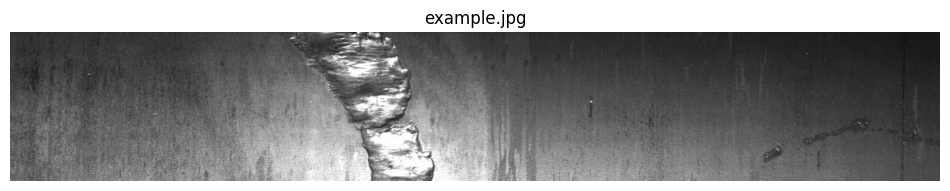

1/1 [==============================] - 0s 35ms/step


<ipython-input-47-659812d51151>:42: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  batch_pred_masks = model.predict_generator(
1it [00:00, 70.74it/s]


In [ ]:
# 예시 url
url = "https://github-production-user-asset-6210df.s3.amazonaws.com/76769044/276505124-c7da01a7-bf8d-47ef-be7b-743a747b0138.jpg"
my_image = requests.get(url)
image = Image.open(BytesIO(my_image.content))

fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("example.jpg")
ax.imshow(image)
ax.axis('off')
plt.show()

# 바이트 스트림으로부터 이미지 디코딩
image_array = np.frombuffer(my_image.content, np.uint8)
cv2_my_img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
# 그레이스케일 변환
my_img = cv2.cvtColor(cv2_my_img, cv2.COLOR_BGR2GRAY)
my_img = my_img.astype(np.float32) / 255.
my_img = np.expand_dims(my_img, axis=-1)

image_path, image_name = os.path.split(url)

test_imgs = pd.DataFrame()
test_imgs["ImageId"] = [image_name]

sub_df = pd.DataFrame()
sub_df["ImageId_ClassId"] = [image_name + "_1", image_name + "_2", image_name + "_3", image_name + "_4"]
sub_df["EncodedPixels"] = [409600]*4
sub_df['ImageId'] = [image_name]*4
test_df = []
batch_idx = [0]

test_generator = DataGenerator(
    batch_idx,
    df=test_imgs,
    expand_img=my_img,
    shuffle=False,
    mode='predict',
    base_path=image_path,
    target_df=sub_df,
    batch_size=1,
    n_classes=4
)
batch_pred_masks = model.predict_generator(
    test_generator,
    workers=1,
    verbose=1,
    use_multiprocessing=False
)
for j, b in tqdm(enumerate(batch_idx)):
    filename = test_imgs['ImageId'].iloc[b]
    image_df = sub_df[sub_df['ImageId'] == filename].copy()
    pred_masks = batch_pred_masks[j, ].round().astype(int)
    pred_rles = build_rles(pred_masks)
    image_df['EncodedPixels'] = pred_rles
    test_df.append(image_df)
test_df = pd.concat(test_df)
test_df.loc[test_df['EncodedPixels'] == '', 'EncodedPixels'] = np.nan
test_df.drop(columns='ImageId', inplace=True)
# Transform class to column
try:
    test_df['fname'], test_df['cls'] = zip(*test_df['ImageId_ClassId'].str.split('_'))
except:
    test_df['fname'], test_df['cls'] = test_df['ImageId'], test_df['ClassId']
test_df['cls'] = test_df['cls'].astype(int)
test_df = test_df.pivot(index='fname',columns='cls',values='EncodedPixels')
test_df['defects'] = test_df.count(axis=1)

In [ ]:
label = test_df.iloc[0].dropna().index.tolist()

In [ ]:
label.remove("defects")

* 예측된 레이블 출력

In [ ]:
print(label)

[3, 4]


In [ ]:
name, mask = make_mask(0)

In [ ]:
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]

In [ ]:
for ch in range(4):
    contours, _ = cv2.findContours(mask[:, :, ch],
                    cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i in range(0, len(contours)):
        cv2.polylines(cv2_my_img, contours[i], True, palet[ch], 10)

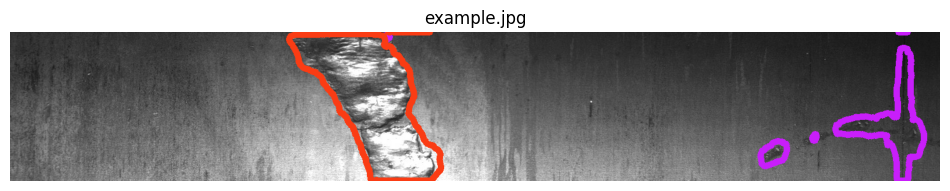

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("example.jpg")
ax.imshow(cv2_my_img)
ax.axis('off')
plt.show()